In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
68*32

2176

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    print(image_batch[0].shape)
    print(image_batch[0].numpy())

(32, 256, 256, 3)
[1 1 0 1 0 1 0 0 0 0 1 0 0 1 2 1 1 0 1 0 0 0 1 1 0 1 0 1 1 0 0 0]
(256, 256, 3)
[[[153. 144. 147.]
  [148. 139. 142.]
  [149. 140. 143.]
  ...
  [163. 157. 161.]
  [162. 156. 160.]
  [167. 161. 165.]]

 [[153. 144. 147.]
  [150. 141. 144.]
  [152. 143. 146.]
  ...
  [170. 164. 168.]
  [170. 164. 168.]
  [175. 169. 173.]]

 [[150. 141. 144.]
  [148. 139. 142.]
  [149. 140. 143.]
  ...
  [169. 163. 167.]
  [171. 165. 169.]
  [176. 170. 174.]]

 ...

 [[113. 103. 102.]
  [127. 117. 116.]
  [117. 107. 106.]
  ...
  [184. 178. 180.]
  [158. 152. 154.]
  [139. 133. 135.]]

 [[125. 115. 114.]
  [118. 108. 107.]
  [130. 120. 119.]
  ...
  [145. 139. 141.]
  [146. 140. 142.]
  [161. 155. 157.]]

 [[109.  99.  98.]
  [119. 109. 108.]
  [128. 118. 117.]
  ...
  [160. 154. 156.]
  [158. 152. 154.]
  [159. 153. 155.]]]


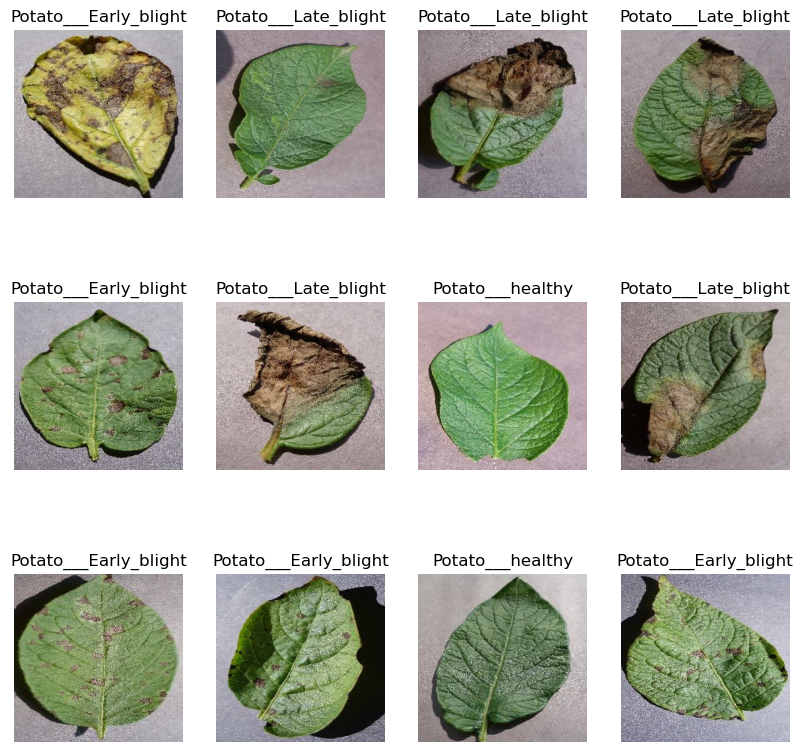

In [26]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
len(dataset)

68

In [10]:
#80% ==> training
#20% ==> 10% validation, 10% test

In [11]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [12]:
train_ds = dataset.take(54)
len(train_ds)

54

In [13]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [14]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [15]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [16]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)
  
  train_size = int(train_split*ds_size)
  val_size = int(val_split*ds_size)

  train_ds = ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

54

In [20]:
len(val_ds)

6

In [21]:
len(test_ds)

8

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [24]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horigontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 1152)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 130,339 (509.14 KB)

 Trainable params: 130,339 (509.14 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 247s 4s/step - accuracy: 0.4593 - loss: 0.9135 - val_accuracy: 0.7500 - val_loss: 0.7425
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 211s 4s/step - accuracy: 0.7638 - loss: 0.5934 - val_accuracy: 0.8073 - val_loss: 0.6371
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.8630 - loss: 0.3400 - val_accuracy: 0.8854 - val_loss: 0.2617
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 211s 4s/step - accuracy: 0.8948 - loss: 0.2704 - val_accuracy: 0.9062 - val_loss: 0.2238
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 223s 4s/step - accuracy: 0.9344 - loss: 0.1829 - val_accuracy: 0.8854 - val_loss: 0.2362
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.9155 - loss: 0.2127 - val_accuracy: 0.9323 - val_loss: 0.1575
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 249s 4s/step - accuracy: 0.9120 - loss: 0.2227 - val_accuracy: 0.8958 - val_loss: 0.2657
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 286s 5s/step - accuracy: 0.9416 - loss: 0.1543 - val_accuracy: 0.9115 - v

In [29]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 582ms/step - accuracy: 0.9729 - loss: 0.0817


In [30]:
scores

[0.07429085671901703, 0.96875]

In [31]:
history

In [32]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 54}

In [33]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Triaining and Validation Loss')

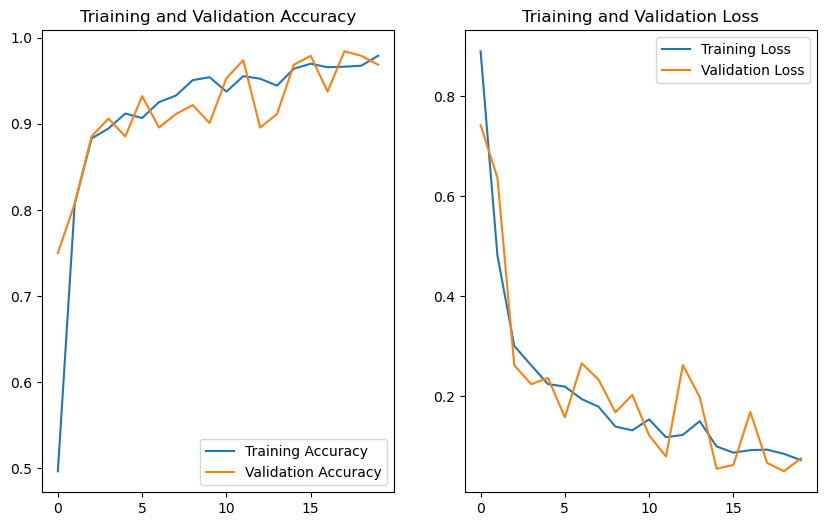

In [35]:
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Triaining and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend()
plt.title('Triaining and Validation Loss')


First image to Predict
Actual Label:  Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step
Predicted Label Potato___Early_blight


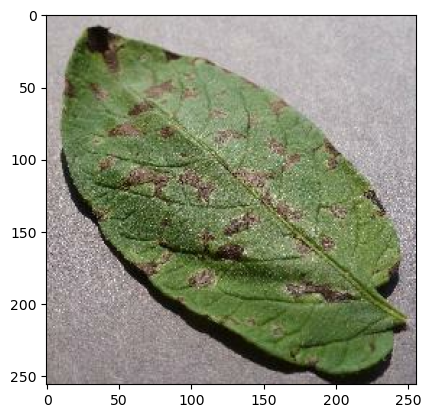

In [36]:
for image_batch, label_batch in test_ds.take(1):
    
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    
    print('First image to Predict')
    plt.imshow(first_image)
    print('Actual Label: ',class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print('Predicted Label', class_names[np.argmax(batch_prediction[0])])

In [37]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    
    predict_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predict_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


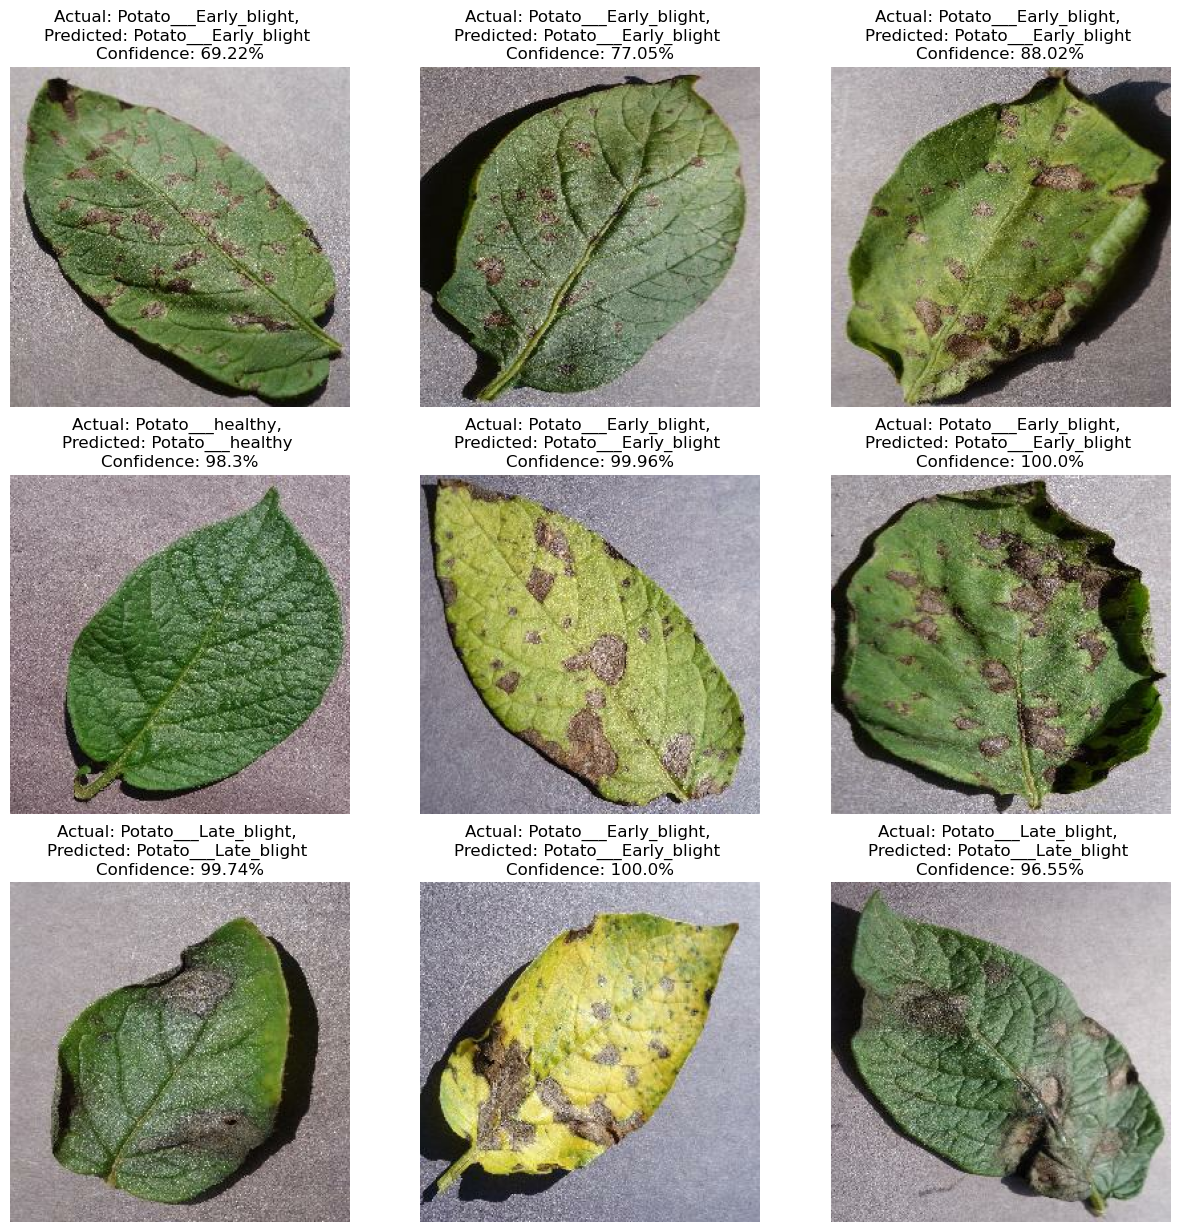

In [38]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class} \nConfidence: {confidence}%")
        
        plt.axis('off')

In [39]:
import os
model_version = max([int(i) for i in os.listdir("../saved_models")+[0]])+1

In [40]:
from keras.models import save_model

save_model(model, "potatoes.keras", save_format="keras")